# Data Scientist Challenge | Marcelo Torres Cisterna

El presente notebook tiene por objetivo el desarrollo de un modelo de IA que permita identificar la probabilidad que un vuelo se atrase o no. Es conocido que éste es un problema que se da en la realidad y lo ideal es minimizar estos atrasos lo máximo posible.

# <font color='darkblue'>Estructura del Notebook</font>

[Sección 1 : Exploratory Data Analysis](#Sección-1-:-Exploratory-Data-Analysis)  
[Sección 2 : Synthetic Features](#Sección-2-:-Synthetic-Features)  
[Sección 3 : Tasas de Atrasos](#Sección-3-:-Tasas-de-Atrasos)  
[Sección 4 : Desarrollo de Modelos](#Sección-4-:-Desarrollo-de-Modelos)  
[Sección 5 : Evaluación de Modelos](#Sección-5-:-Evaluación-de-Modelos)  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv("dataset_SCL.csv")

C:\Users\marce\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Sección 1 : Exploratory Data Analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


In [4]:
data.describe()

,DIA,MES,AÑO
count,68206.000000,68206.000000,68206.000000
mean,15.714790,6.622585,2017.000029
std,8.782886,3.523321,0.005415
min,1.000000,1.000000,2017.000000
25%,8.000000,3.000000,2017.000000
50%,16.000000,7.000000,2017.000000
75%,23.000000,10.000000,2017.000000
max,31.000000,12.000000,2018.000000


Primero, notamos que existen algunas Features que corresponden a fechas, pero no están en formato datetime, formato que nos facilita mucho más el trabajo para obtener datos a partir de fechas.

In [5]:
data[["Fecha-I", "Fecha-O"]] = data[["Fecha-I", "Fecha-O"]].apply(pd.to_datetime)

Usando el nuevo formato, obtenemos algunas Features nuevas para nuestro análisis.

In [6]:
data['year-I'] = [x.year for x in data["Fecha-I"]]
data['year-O'] = [x.year for x in data["Fecha-O"]]
data['month-I'] = [x.month for x in data["Fecha-I"]]
data['month-O'] = [x.month for x in data["Fecha-O"]]    
data['day-I'] = [x.day for x in data["Fecha-I"]]
data['day-O'] = [x.day for x in data["Fecha-O"]]    

Borramos features repetidas

In [7]:
data.drop(["DIA" , "MES" , "AÑO"] , axis = 1 , inplace = True)

In [8]:
data.groupby(["year-I","year-O"]).size()

year-I  year-O
2017    2017      68204
        2018          2
dtype: int64

Notamos que el dataset se basa en datos del año 2017, hay dos vuelos cuya fecha de operación es de 2018 y eso es porque el vuelo estaba programado para el 31 de Diciembre y operó pasada las 00 horas

## Sección 1.1 : Análisis Por Fechas

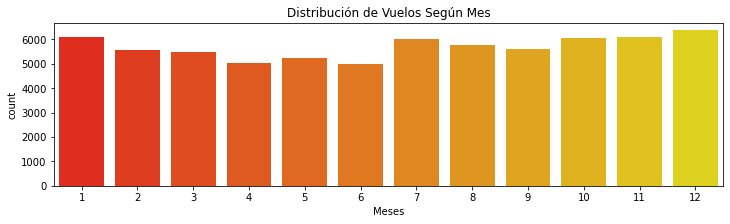

In [9]:
plt.figure(figsize =(12,3))
plt.title("Distribución de Vuelos Según Mes")
sns.countplot(x = "month-I" , data = data , palette = "autumn")
plt.xlabel("Meses");

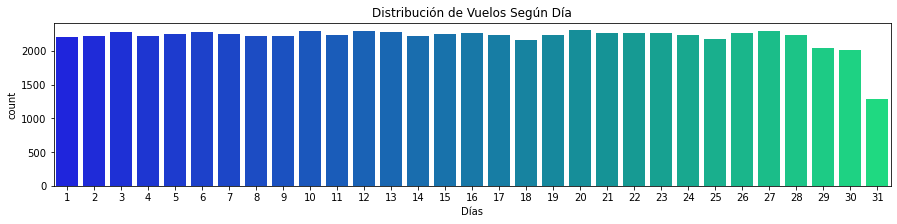

In [10]:
plt.figure(figsize =(15,3))
plt.title("Distribución de Vuelos Según Día")
sns.countplot(x = "day-I" , data = data , palette = "winter")
plt.xlabel("Días");

Notamos que en cuanto a la distribución __Mensual__ de los datos, hay tres fechas principales en las que se presenta una mayor cantidad de vuelos: __Enero, Julio y Diciembre__. A priori, una conclusión de lo anterior es debido a las fechas relacionadas a las vacaciones de verano e invierno. Por otra parte, cuando analizamos el comportamiento diario notamos un patrón más o menos similar a excepción del día __31 de Diciembre__, lo anterior ya que es el día de año nuevo y muchas personas probablemente quieran pasar ese día festivo con familiares y amigos.

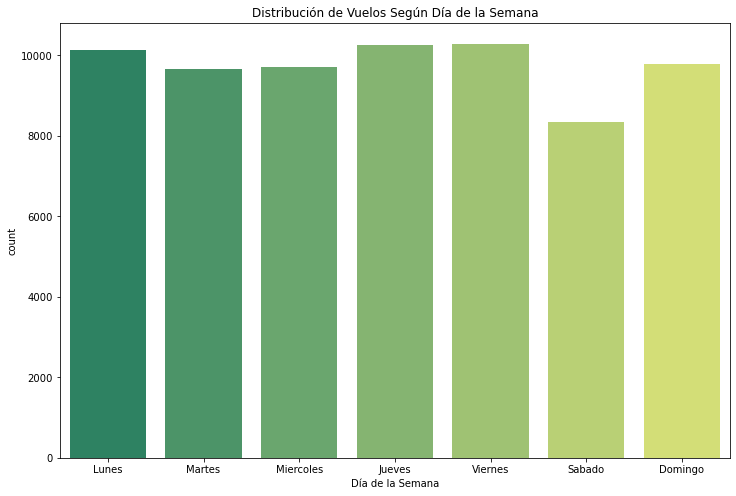

In [11]:
plt.figure(figsize =(12,8))
plt.title("Distribución de Vuelos Según Día de la Semana")
sns.countplot(x = "DIANOM" , data = data , palette = "summer" , order=['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes' , 'Sabado' , 'Domingo'])
plt.xlabel("Día de la Semana");

En cuanto a día de la semana __Lunes , Jueves y Viernes__ lideran los vuelos.

## Sección 1.2 : Análisis Por Origen y Destino

In [12]:
data.groupby("Ori-I").size()

Ori-I
SCEL    68206
dtype: int64

In [13]:
data.groupby("Ori-O").size()

Ori-O
SCEL    68206
dtype: int64

In [14]:
data.groupby("SIGLAORI").size()

SIGLAORI
Santiago    68206
dtype: int64

Aquí es donde notamos algo interesante. Todos los vuelos del dataset tienen como origen tanto programado como de operación la ciudad de Santiago. Lo anterior quiere decir que todos los vuelos son solamente vuelos __desde__ Santiago y no __desde y hacia__ como menciona la descripción del dataset. Por lo tanto éstas columnas no nos sirven y se eliminan.

In [15]:
data.drop(["Ori-I" , "Ori-O" , "SIGLAORI"] , axis = 1 , inplace = True)

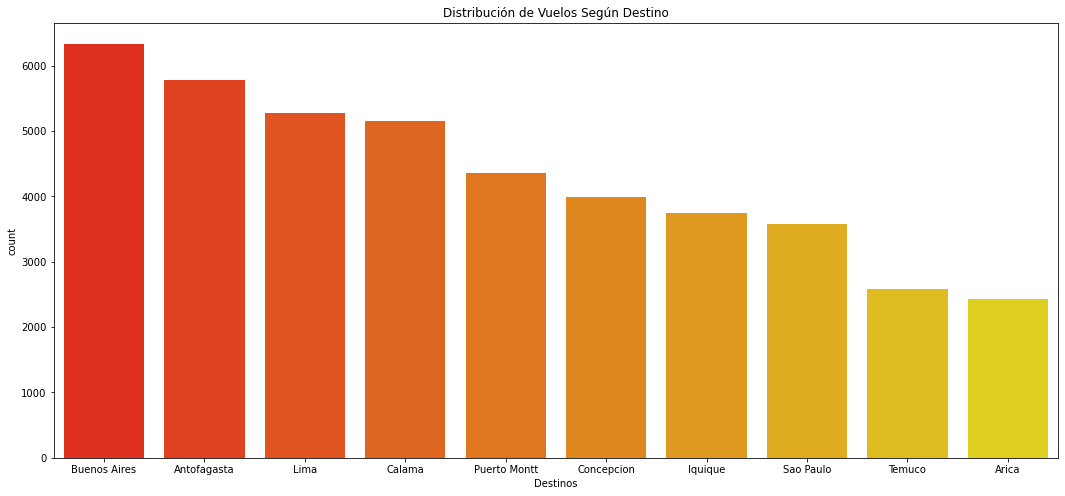

In [16]:
plt.figure(figsize =(18,8))
plt.title("Distribución de Vuelos Según Destino")
sns.countplot(x = "SIGLADES" , data = data , palette = "autumn" , order = data['SIGLADES'].value_counts().index[:10]);
plt.xlabel("Destinos");

In [17]:
data["DestVerificacion"] = data["Des-I"] == data["Des-O"]

In [18]:
data.groupby("DestVerificacion").size()

DestVerificacion
False       28
True     68178
dtype: int64

La ubicación con la mayor cantidad de viajes corresponde a la ciudad de __Buenos Aires__ seguido de __Antofagasta__ . Otra cosa importante que notamos es que hay 28 casos en los que el __Destino Programado__ es diferente al __Destino de Operación__ . Esta situación resulta un poco extraña ya que cuando uno agenda un vuelo, uno espera llegar al destino que fue solicitado y no otro. El hecho que existieran algunos vuelos en los que estos destinos eran diferentes se pudo haber debido por ejemplo a alguna falla técnica que generó algún aterrizaje de emergencia o algo por el estilo. Para efectos del estudio, se considerarán como __Outliers__.

In [19]:
data = data[data.DestVerificacion == True]

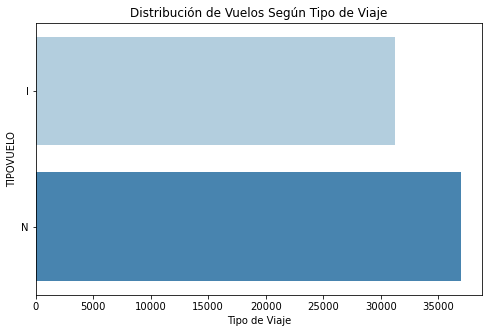

In [20]:
plt.figure(figsize =(8,5))
plt.title("Distribución de Vuelos Según Tipo de Viaje")
sns.countplot(y = "TIPOVUELO" , data = data , palette = "Blues");
plt.xlabel("Tipo de Viaje");

Por otra parte, la cantidad de vuelos tanto __Nacionales como Internacionales__ es más o menos similar.

## Sección 1.3 : Análisis Por Aerolínea

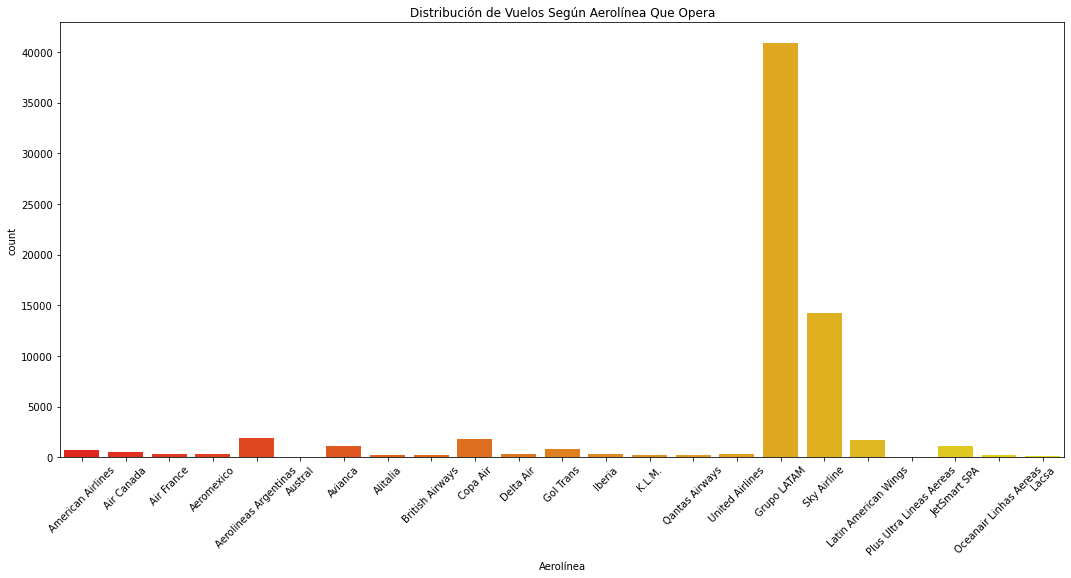

In [21]:
plt.figure(figsize =(18,8))
plt.title("Distribución de Vuelos Según Aerolínea Que Opera")
sns.countplot(x = "OPERA" , data = data , palette = "autumn");
plt.xlabel("Aerolínea")
plt.xticks(rotation=45);

In [22]:
data["EmpVer"] = data["Emp-I"] == data["Emp-O"]

In [23]:
data.groupby("EmpVer").size()

EmpVer
False    18659
True     49519
dtype: int64

In [24]:
data[data.EmpVer == False].head()

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLADES,year-I,year-O,month-I,month-O,day-I,day-O,DestVerificacion,EmpVer
345,2017-01-21 22:30:00,2291,SABE,AUT,2017-01-21 22:28:00,2291,SABE,ARG,Sabado,I,Austral,Buenos Aires,2017,2017,1,1,21,21,True,False
814,2017-01-01 07:14:00,624,SPJC,AVA,2017-01-01 07:11:00,624,SPJC,LRC,Domingo,I,Avianca,Lima,2017,2017,1,1,1,1,True,False
815,2017-01-02 07:00:00,624,SPJC,AVA,2017-01-02 07:05:00,624,SPJC,LRC,Lunes,I,Avianca,Lima,2017,2017,1,1,2,2,True,False
816,2017-01-03 07:14:00,624,SPJC,AVA,2017-01-03 07:14:00,624,SPJC,LRC,Martes,I,Avianca,Lima,2017,2017,1,1,3,3,True,False
817,2017-01-04 07:00:00,624,SPJC,AVA,2017-01-04 07:24:00,624,SPJC,LRC,Miercoles,I,Avianca,Lima,2017,2017,1,1,4,4,True,False


Aquí notamos otra característica interesante de los datos. Existe una gran cantidad de vuelos en los que la empresa que en realidad operó fue diferente a la que debió haber operado. Sin embargo, puede que la aerolínea que en realidad operó sea parte de un Grupo, por lo que la tesis anterior estaría equivocada. Para lo anterior creamos una columna que mapea código de aerolínea con nombre de la aerolínea

In [25]:
aerodict = data[["Emp-I" , "OPERA"]].drop_duplicates()
aerodict.rename(columns = {
    'Emp-I' : 'Emp-O',
    'OPERA' : 'OPERA-O'
} , inplace = True)

In [26]:
data = pd.merge(data,aerodict, how = "left")
data['OPERA-O'] = data["OPERA-O"].fillna(value = "Unknown")

In [27]:
data[data['OPERA-O'] == "Unknown"].groupby("Emp-I").size()

Emp-I
AVA      2
LAW     27
QFU    194
dtype: int64

In [28]:
data[(data['OPERA-O'] == "Unknown") & (data["Emp-I"] == "AVA")]

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLADES,year-I,year-O,month-I,month-O,day-I,day-O,DestVerificacion,EmpVer,OPERA-O
39174,2017-08-11 06:14:00,624,SPJC,AVA,2017-08-11 08:14:00,922,SPJC,TPU,Viernes,I,Avianca,Lima,2017,2017,8,8,11,11,True,False,Unknown
39180,2017-08-17 17:25:00,624,SPJC,AVA,2017-08-17 19:21:00,5924,SPJC,TPU,Jueves,I,Avianca,Lima,2017,2017,8,8,17,17,True,False,Unknown


In [29]:
data[(data['OPERA-O'] == "Unknown") & (data["Emp-I"] == "QFU")].head(2)

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLADES,year-I,year-O,month-I,month-O,day-I,day-O,DestVerificacion,EmpVer,OPERA-O
845,2017-01-01 13:35:00,28,YSSY,QFU,2017-01-01 14:56:00,28,YSSY,QFA,Domingo,I,Qantas Airways,Sydney,2017,2017,1,1,1,1,True,False,Unknown
846,2017-01-03 13:35:00,28,YSSY,QFU,2017-01-03 14:12:00,28,YSSY,QFA,Martes,I,Qantas Airways,Sydney,2017,2017,1,1,3,3,True,False,Unknown


Existen 3 códigos de aerolíneas que no cuentan con un nombre en particular. Notamos que uno de ellos es __QFA__ que podemos intuir que pertenece a la misma aerolínea que __QFU__ por lo que haremos ese reemplazo. Los otros vuelos de las aerolíneas AVA y LAW, al ser una cantidad muy pequeña los omitiremos

In [30]:
data1 = data[data["OPERA-O"] != "Unknown"]
data2 = data[(data["OPERA-O"] == "Unknown") & (data["Emp-I"] == "QFU")]
data2["OPERA-O"] = "Qantas Airways"
data = pd.concat([data1 , data2])
data["EmpVer2"] = data["OPERA"] == data["OPERA-O"]
data.groupby("EmpVer2").size()

<ipython-input-30-cae10daab30d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["OPERA-O"] = "Qantas Airways"


EmpVer2
False      272
True     67877
dtype: int64

In [36]:
data[data.EmpVer2 == False].groupby("Emp-I").size()

Emp-I
ARG      5
AUT      2
AVA    265
dtype: int64

In [31]:
data[(data.EmpVer2 == False) & (data["Emp-I"] != "AVA")]

,Fecha-I,Vlo-I,Des-I,Emp-I,Fecha-O,Vlo-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLADES,year-I,year-O,month-I,month-O,day-I,day-O,DestVerificacion,EmpVer,OPERA-O,EmpVer2
345,2017-01-21 22:30:00,2291,SABE,AUT,2017-01-21 22:28:00,2291,SABE,ARG,Sabado,I,Austral,Buenos Aires,2017,2017,1,1,21,21,True,False,Aerolineas Argentinas,False
11987,2017-03-04 22:30:00,2291,SABE,ARG,2017-03-04 22:34:00,2291,SABE,AUT,Sabado,I,Aerolineas Argentinas,Buenos Aires,2017,2017,3,3,4,4,True,False,Austral,False
11988,2017-03-11 22:30:00,2291,SABE,ARG,2017-03-11 22:39:00,2291,SABE,AUT,Sabado,I,Aerolineas Argentinas,Buenos Aires,2017,2017,3,3,11,11,True,False,Austral,False
11989,2017-03-25 22:30:00,2291,SABE,ARG,2017-03-25 22:39:00,2291,SABE,AUT,Sabado,I,Aerolineas Argentinas,Buenos Aires,2017,2017,3,3,25,25,True,False,Austral,False
32735,2017-07-22 19:50:00,2297,SABE,AUT,2017-07-22 19:46:00,1297,SABE,ARG,Sabado,I,Austral,Buenos Aires,2017,2017,7,7,22,22,True,False,Aerolineas Argentinas,False
62152,2017-12-20 19:25:00,2287,SAEZ,ARG,2017-12-20 20:17:00,1287,SAEZ,AUT,Miercoles,I,Aerolineas Argentinas,Buenos Aires,2017,2017,12,12,20,20,True,False,Austral,False
62153,2017-12-22 19:25:00,2287,SAEZ,ARG,2017-12-22 21:30:00,2287,SAEZ,AUT,Viernes,I,Aerolineas Argentinas,Buenos Aires,2017,2017,12,12,22,22,True,False,Austral,False


Realizando un poco de investigación, resulta que el nombre anterior de __AVIANCA__ era __LACSA__. Por otra parte notamos de la tabla superior que __Austral__ y __Aerolíneas Argentinas__ corresponden al mismo grupo. De ésta forma logramos rearmar el conjunto de datos verificando que aerolíneas de operación y programadas son correctas. Limpiamos el dataset eliminando variables que no utilizaremos y luego procedemos con la sección 2.

In [42]:
data = data.drop([ "DestVerificacion" , "EmpVer" , "OPERA-O" , "EmpVer2"] , axis = 1)

# Sección 2 : Synthetic Features

In [148]:
synthetic_features = pd.DataFrame(columns = ['fecha_I' , 'fecha_O','temporada_alta', 'dif_min', 'atraso_15' , 'periodo_dia'])

In [149]:
synthetic_features['fecha_I'] = data['Fecha-I']
synthetic_features['fecha_O'] = data['Fecha-O']

## Sección 2.1 : Temporada Alta

In [150]:
i1 = pd.Timestamp('2017-12-15T235959')
i2 = pd.Timestamp('2017-03-03T0000')
i3 = pd.Timestamp('2017-07-15T0000')
i4 = pd.Timestamp('2017-07-31T235959')
i5 = pd.Timestamp('2017-09-11T0000')
i6 = pd.Timestamp('2017-09-30T235959')

In [151]:
temporada_alta = []
for i in data['Fecha-I']:
    if (i > i1) | (i < i2) | (i3 <= i <= i4) | (i5 <= i <= i6):
        temporada_alta.append(1)
    else:
        temporada_alta.append(0)
synthetic_features['temporada_alta'] = temporada_alta

## Sección 2.2 : Diferencia Minutos

In [153]:
synthetic_features["late"] = [1 if i.fecha_I <= i.fecha_O else 0 for i in synthetic_features.itertuples()]
synthetic_features["dif_min"] = [int(np.round((i.fecha_I - i.fecha_O).seconds / 60 , 0)) if i.late == 0 else int(np.round((i.fecha_O - i.fecha_I).seconds / 60 , 0)) for i in synthetic_features.itertuples()]
synthetic_features.drop(["late"] , axis = 1 , inplace = True)

## Sección 2.3 : Atraso 15

In [157]:
synthetic_features["atraso_15"] = [1 if x > 15 else 0 for x in synthetic_features.dif_min]

## Sección 2.4 : Periodo Dia

In [169]:
periodo_dia = []
for i in synthetic_features.itertuples():
    if (5 <= i.fecha_I.hour < 12):
        periodo_dia.append("mañana")
    elif (12 <= i.fecha_I.hour < 19):
        periodo_dia.append("tarde")
    else:
        periodo_dia.append("noche")
synthetic_features["periodo_dia"] = periodo_dia

In [171]:
synthetic_features.to_csv("synthetic_features.csv")

In [174]:
synthetic_features.drop(["fecha_I" , "fecha_O"] , axis = 1 , inplace = True)

In [176]:
data = pd.concat([data , synthetic_features] , axis = 1)

# Sección 3 : Tasas de Atrasos

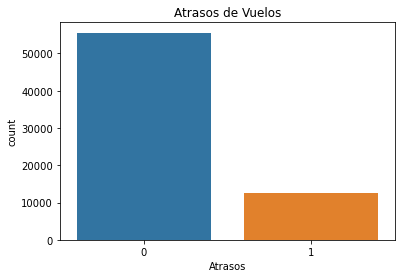

In [183]:
plt.title("Atrasos de Vuelos")
sns.countplot(x='atraso_15' , data=data);
plt.xlabel("Atrasos");

In [247]:
def rates(data , category):
    vuelos = pd.crosstab(data[category], data['atraso_15'])
    vuelos.columns = ["no_atrasado" , "atrasado"]
    vuelos['total_vuelos'] = vuelos.no_atrasado + vuelos.atrasado
    tasas = pd.crosstab(data[category], data['atraso_15']).apply(lambda r: (r/r.sum()).round(2) * 100, axis=1)
    tasas.columns = ["rate_no_atrasado" , "rate_atrasado"]
    df = pd.concat([vuelos , tasas] , axis = 1)
    return df

## Sección 3.1 : Destino

In [248]:
dest_rates = rates(data , 'SIGLADES')

In [250]:
dest_rates = dest_rates.sort_values(by = "rate_atrasado" , ascending = False)[:15]

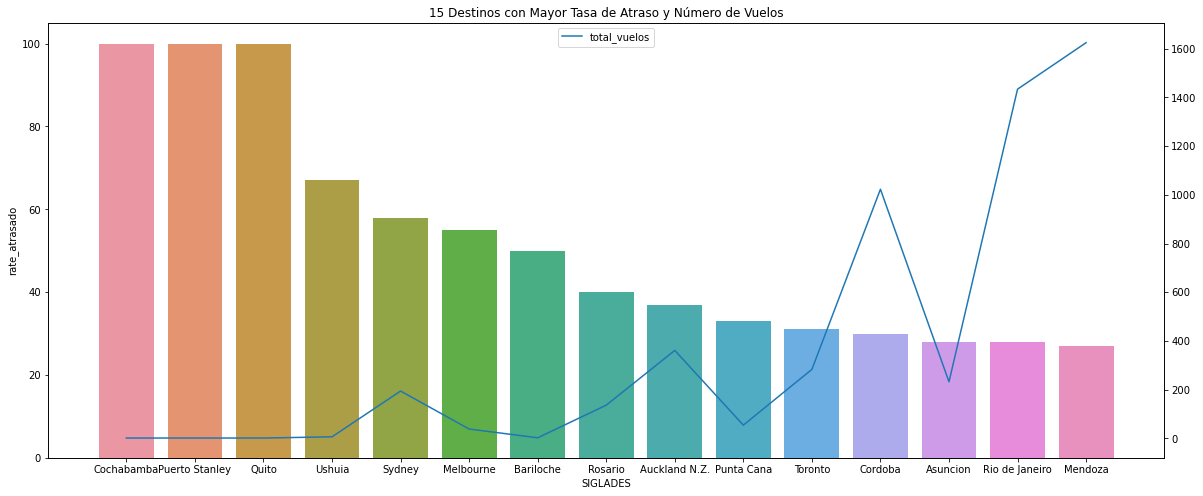

In [264]:
plt.figure(figsize = (20,8))
plt.title("15 Destinos con Mayor Tasa de Atraso y Número de Vuelos")
sns.barplot(x = dest_rates.index, y = "rate_atrasado" , data = dest_rates)
dest_rates['total_vuelos'].plot(secondary_y=True)
plt.legend(loc="upper center");

## Sección 3.2 : Aerolínea

In [269]:
aero_rates = rates(data , 'OPERA')

In [274]:
aero_rates.sort_values(by = "rate_atrasado" , ascending = False).head(10)

,no_atrasado,atrasado,total_vuelos,rate_no_atrasado,rate_atrasado
OPERA,,,,,
Plus Ultra Lineas Aereas,19,30,49,39.0,61.0
Qantas Airways,81,113,194,42.0,58.0
Air Canada,307,258,565,54.0,46.0
Latin American Wings,979,667,1646,59.0,41.0
Gol Trans,518,287,805,64.0,36.0
Avianca,846,304,1150,74.0,26.0
Aerolineas Argentinas,1481,468,1949,76.0,24.0
Austral,59,15,74,80.0,20.0
Grupo LATAM,33573,7301,40874,82.0,18.0


## Sección 3.3 : Mes

In [281]:
mes_rates = rates(data , 'month-O')

In [282]:
mes_rates

,no_atrasado,atrasado,total_vuelos,rate_no_atrasado,rate_atrasado
month-O,,,,,
1,5116,964,6080,84.0,16.0
2,4716,842,5558,85.0,15.0
3,4848,630,5478,88.0,12.0
4,4433,585,5018,88.0,12.0
5,4409,827,5236,84.0,16.0
6,4129,852,4981,83.0,17.0
7,4232,1755,5987,71.0,29.0
8,4746,994,5740,83.0,17.0
9,4643,967,5610,83.0,17.0


## Sección 3.4 : Día

In [284]:
day_rates = rates(data , 'DIANOM')

In [286]:
day_rates

,no_atrasado,atrasado,total_vuelos,rate_no_atrasado,rate_atrasado
DIANOM,,,,,
Domingo,8214,1576,9790,84.0,16.0
Jueves,8202,2043,10245,80.0,20.0
Lunes,8078,2043,10121,80.0,20.0
Martes,8025,1627,9652,83.0,17.0
Miercoles,8054,1658,9712,83.0,17.0
Sabado,6984,1363,8347,84.0,16.0
Viernes,8001,2281,10282,78.0,22.0


## Sección 3.5 : Temporada

In [288]:
temp_rates = rates(data , 'temporada_alta')

In [289]:
temp_rates

,no_atrasado,atrasado,total_vuelos,rate_no_atrasado,rate_atrasado
temporada_alta,,,,,
0,37590,8239,45829,82.0,18.0
1,17968,4352,22320,81.0,19.0


## Sección 3.6 : Tipo de Vuelo

In [291]:
tipo_rates = rates(data , 'TIPOVUELO')

In [293]:
tipo_rates

,no_atrasado,atrasado,total_vuelos,rate_no_atrasado,rate_atrasado
TIPOVUELO,,,,,
I,24169,7028,31197,77.0,23.0
N,31389,5563,36952,85.0,15.0


# Sección 4 : Desarrollo de Modelos

# Sección 5 : Evaluación de Modelos

[Another Cell](#another_cell)